# Deep Convolutional

In [ ]:
%pip install -q imageio pydot tensorflow-gpu==2.9.1 keras matplotlib graphviz moviepy scikit-image


## Import all Modules and Configure GPU

In [1]:
import os
import keras_tuner as kt
from numpy import asarray
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import os.path
import math


In [2]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
   # mixed_precision.set_global_policy('mixed_float16')
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


2022-06-10 16:41:32.697186: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-10 16:41:32.719613: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-10 16:41:32.719827: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
tf.__version__


'2.9.1'

## Load and process data.
Will take advantage of built in tensorflow/keras for asynchronous load dataset from disk, rather force all data to be loaded in memory.

In [4]:
def load_from_directory(data_dir, train_subdir, test_subdir, image_size, batch_size):
    def configure_for_performance(ds, AUTOTUNE):
        ds = ds.cache()
        ds = ds.prefetch(buffer_size=AUTOTUNE)
        return ds

    #
    data_train_dir = pathlib.Path(data_dir.as_posix() + "/" + train_subdir)
    image_count = len(list(data_train_dir.glob('**/*.??g')))
    print("{0}: Found {1} files".format(data_train_dir, image_count))

    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_train_dir,
        interpolation='bilinear',
        color_mode='grayscale',
        label_mode=None,
        follow_links=True,
        shuffle=False,
        image_size=image_size,
        batch_size=batch_size)

    #
    data_test_dir = pathlib.Path(data_dir.as_posix() + "/" + test_subdir)
    image_count = len(list(data_test_dir.glob('**/*.??g')))
    print("{0}: Found {1} files".format(data_test_dir, image_count))

    test_ds = tf.keras.utils.image_dataset_from_directory(
        data_test_dir,
        interpolation='bilinear',
        color_mode='rgb',
        label_mode=None,
        follow_links=True,
        shuffle=False,
        image_size=image_size,
        batch_size=batch_size)

    #
    AUTOTUNE = tf.data.AUTOTUNE
    normalization_layer = tf.keras.layers.Rescaling(1.0 / 255.0)

    # Translate [0,255] -> [-1, 1]
    normalized_train_ds = train_ds.map(lambda x: normalization_layer(x) * 2.0 - 1.0)

    # Translate [0,255] -> [-1, 1]
    normalized_test_ds = test_ds.map(lambda x: normalization_layer(x) * 2.0 - 1.0)

    return configure_for_performance(tf.data.Dataset.zip((normalized_train_ds, normalized_test_ds)).shuffle(64), AUTOTUNE)


In [5]:
BATCH_SIZE = 64
IMAGE_SIZE = (64, 64)
EPOCHS = 48

data_directory_path = "data-colorize/"
data_dir = pathlib.Path(data_directory_path)

train_images = load_from_directory(data_dir, "", "", IMAGE_SIZE, BATCH_SIZE)  # .batch(batch_size=BATCH_SIZE)

print("Number of batches {0} of {1} elements".format(
    len(train_images), BATCH_SIZE))


data-colorize: Found 14397 files
Found 14397 files belonging to 1 classes.


2022-06-10 16:41:33.224527: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-10 16:41:33.225363: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-10 16:41:33.225524: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-10 16:41:33.225638: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

data-colorize: Found 14397 files
Found 14397 files belonging to 1 classes.
Number of batches 225 of 64 elements


2022-06-10 16:41:34.709403: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


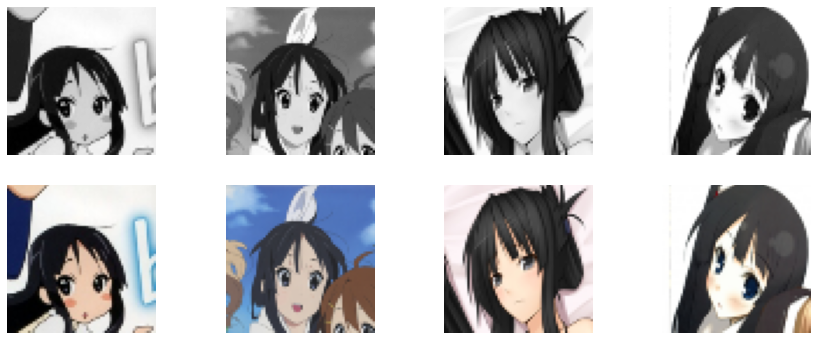

In [6]:

num_examples_to_generate = 4

plt.figure(figsize=(15, 6))
for images in train_images.take(1):
    for i in range(0, num_examples_to_generate):
        ax = plt.subplot(2, num_examples_to_generate, i + 1)
        trainImage, expectedImage = images
        # Transform pixel values from [-1,1] to [0,1]
        plt.imshow((trainImage[i, :, :, :].numpy().astype(dtype='float32') + 1.0) / 2.0, cmap='gray')
        plt.axis("off")
        ax = plt.subplot(2, num_examples_to_generate, num_examples_to_generate + 1 + i)
        # Transform pixel values from [-1,1] to [0,1]
        plt.imshow((expectedImage[i, :, :, :].numpy().astype(dtype='float32') + 1.0) / 2.0)
        plt.axis("off")
plt.show()


In [9]:
def create_model(hp, input_shape):
    model = tf.keras.Sequential()

    init = tf.keras.initializers.TruncatedNormal(stddev=0.02)

    kernel_init = hp.Choice('kernel_initializer', ['uniform', 'lecun_uniform', 'normal', 'zero',
                                                   'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'])

    model.add(layers.Input(input_shape))

    downscale_number_layer_offset = hp.Int('downscale_number_layer_offset', min_value=3, max_value=6, step=1)

    n2 = math.log2(float(IMAGE_SIZE[0]))
    num_layers = max(int(n2) - downscale_number_layer_offset, 0)

    hp_kernel_filter_size_l0 = hp.Int('kernel_filter_downscale', min_value=5, max_value=8, step=1)

    for i in range(0, num_layers + 1):
        filter_size = 2 ** (i + hp_kernel_filter_size_l0)

        model.add(layers.Conv2D(filter_size, (3, 3), activation='relu', padding='same', kernel_initializer=kernel_init))
        model.add(layers.Conv2D(filter_size, (3, 3), activation='relu', padding='same', strides=2, kernel_initializer=kernel_init))

        #model.add(layers.Conv2D(filter_size, (3, 3), activation='relu', padding='same', kernel_initializer=kernel_init))

#        model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    hp_kernel_filter_size_l1 = hp.Int('kernel_filter_upscale', min_value=5, max_value=9, step=1)

    for i in range(0, num_layers + 1):
        filter_size = 2 ** (hp_kernel_filter_size_l1 - i)

        #model.add(layers.Conv2D(filter_size, (2, 2), strides=(2, 2), activation='relu', padding='same'))
        model.add(layers.UpSampling2D(size=(2, 2)))

        model.add(layers.Conv2D(filter_size, (3, 3), activation='relu', padding='same', kernel_initializer=kernel_init))

        #model.add(layers.Conv2D(filter_size, (3, 3), activation='relu', padding='same', kernel_initializer=kernel_init))

    model.add(layers.Conv2D(3, (3, 3), activation='tanh', padding='same', kernel_initializer=kernel_init))

    hp_optimizer = hp.Choice('optimizer', ['sgd', 'adam', 'rmsprop'])

    model.compile(optimizer=hp_optimizer,
                  loss='mse',
                  metrics=['accuracy'])

    return model


In [10]:
image_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 1)

def model_builder(hp):
    model = create_model(hp, image_shape)
    return model


tuner = kt.Hyperband(model_builder,
                     objective='accuracy',
                     max_epochs=16,
                     factor=5,
                     directory='cache',
                     project_name=str.format('Colorizing - GrayScale Input - {0}', "Anime"))

stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='loss', patience=5)
tuner.search(train_images, epochs=EPOCHS, batch_size=BATCH_SIZE,
             callbacks=[stop_early], verbose=1)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_models = tuner.get_best_models(4)

model = tuner.hypermodel.build(best_hps)
model.summary()


Trial 13 Complete [00h 01m 59s]
accuracy: 0.6573872566223145

Best accuracy So Far: 0.6573872566223145
Total elapsed time: 00h 18m 54s
INFO:tensorflow:Oracle triggered exit
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 64, 64, 32)        320       
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 16, 64)        36928     
                                                                 
 up_sampling2d_2 (UpSampling  (None, 32, 32, 64)       0         
 2D)                                                             
             

In [15]:
def showResult(model, batchImage):
    maxNumImages = 5
    pred = (model.predict(batchImage) + 1.0) / 2.0
    nrElements = min(len(pred), maxNumImages)

    fig = plt.figure(figsize=(maxNumImages * 2, maxNumImages))
    for image in batchImage:
        for i in range(nrElements):
            _, expectedImage = image

            ax = plt.subplot(2, maxNumImages, i + 1)
            # Transform pixel values from [-1,1] to [0,1]
            plt.imshow((expectedImage[i, :, :, :].numpy().astype(dtype='float32') + 1.0) / 2.0)
            plt.axis("off")
            ax = plt.subplot(2, maxNumImages, maxNumImages + 1 + i)
            # Transform pixel values from [-1,1] to [0,1]
            plt.imshow(asarray(pred[i, :, :, :]).astype(dtype='float32'))
            plt.axis("off")
    plt.close()
    return fig

class save_images(tf.keras.callbacks.Callback):

    def __init__(self, trainData, **kwargs):
        super(tf.keras.callbacks.Callback, self).__init__(**kwargs)
        self.trainData = trainData

    def on_epoch_end(self, epoch, logs=None):
        fig = showResult(self.model, self.trainData.take(1))
        fig.savefig("animeColor{0}.png".format(epoch))

In [16]:


model_history = {}

checkpoint_path = "checkpoints/training_anime_coloring_grayscale/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)


# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0)

checkpoint = tf.train.Checkpoint(model=model)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path)).expect_partial()

# The model weights (that are considered the best) are loaded into the model.
if os.path.exists(checkpoint_path):
    model.load_weights(checkpoint_path)


model_history = model.fit(train_images,
                          epochs=EPOCHS*10,
                          batch_size=1,
                          verbose=1, callbacks=[cp_callback, save_images(train_images)])


model.save_weights(checkpoint_path)


Epoch 1/480
225/225 [==============================] - ETA: 0s - loss: 0.0770 - accuracy: 0.6489
Epoch 1: saving model to checkpoints/training_anime_coloring_grayscale/cp.ckpt
225/225 [==============================] - 3s 11ms/step - loss: 0.0770 - accuracy: 0.6489
Epoch 2/480
223/225 [============================>.] - ETA: 0s - loss: 0.0769 - accuracy: 0.6494
Epoch 2: saving model to checkpoints/training_anime_coloring_grayscale/cp.ckpt
225/225 [==============================] - 2s 11ms/step - loss: 0.0769 - accuracy: 0.6488
Epoch 3/480
223/225 [============================>.] - ETA: 0s - loss: 0.0768 - accuracy: 0.6492
Epoch 3: saving model to checkpoints/training_anime_coloring_grayscale/cp.ckpt
225/225 [==============================] - 3s 11ms/step - loss: 0.0768 - accuracy: 0.6487
Epoch 4/480
225/225 [==============================] - ETA: 0s - loss: 0.0767 - accuracy: 0.6485
Epoch 4: saving model to checkpoints/training_anime_coloring_grayscale/cp.ckpt
225/225 [=================

In [17]:
model.save("dc-anime-colorization.h5")


# Result

In [18]:
#loss, acc = model.evaluate(test_images, test_labels, verbose=2)

In [19]:
def plotCostHistory(history, loss_label="", val_label="", title="", x_label="", y_label=""):
    plt.figure()
    for k, v in history.items():
        plt.plot(v, label=k)
    plt.title(label=title)
    plt.ylabel(ylabel=y_label)
    plt.xlabel(xlabel=x_label)
    plt.legend(loc="upper left")
    plt.show()
    plt.savefig(title + ".png")


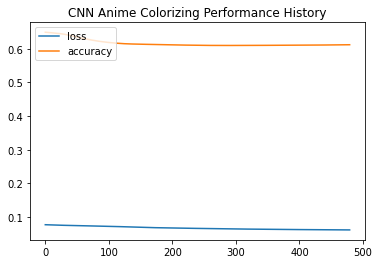

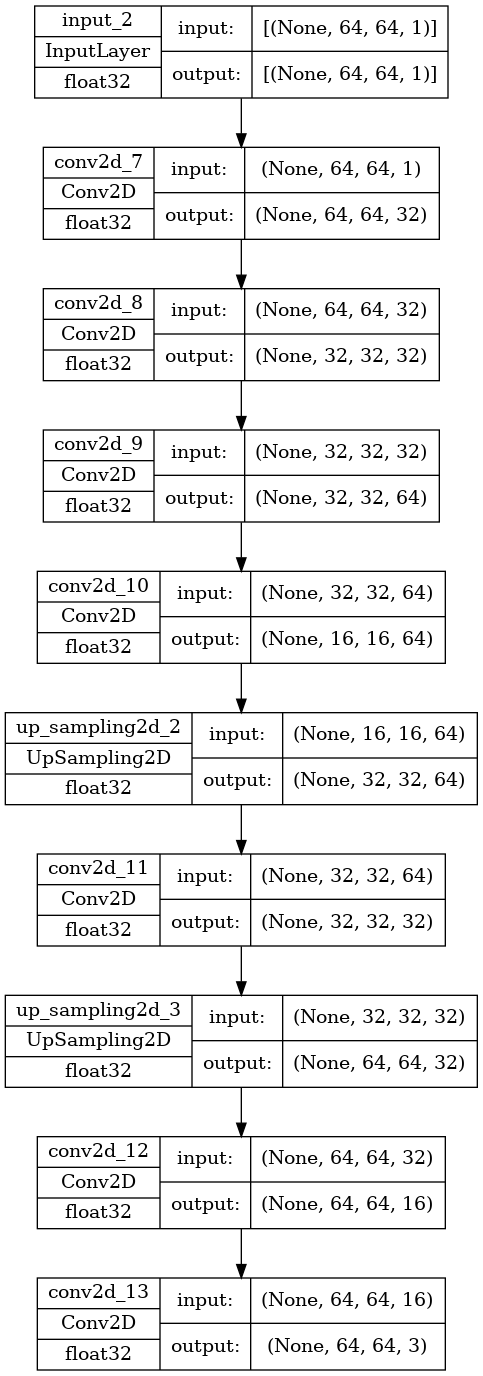

<Figure size 432x288 with 0 Axes>

In [20]:
plotCostHistory(model_history.history, title=str.format(
    "CNN {0} Performance History", "Anime Colorizing"))

tf.keras.utils.plot_model(
    model, to_file=str.format('cnn_{0}_model.png', "Anime Colorizing"), show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96,
    layer_range=None
)
